In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

In [4]:
class Descriminator(nn.Module):
    def __init__(self, img_dim):
        super(Descriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, img_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 3e-4
z_dim = 64
img_dim = 28 * 28 * 1
batch_size = 64
epochs = 100

In [7]:
%%time
disc = Descriminator(img_dim).to(device)
gen = Generator(z_dim, img_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
optim_disc = optim.Adam(disc.parameters(), lr=lr)
optim_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),]
)

dataset = torchvision.datasets.FashionMNIST(
    root='dataset/', transform=transforms, download=True
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.67MB/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 61.7MB/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.6MB/s]


Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw

CPU times: user 487 ms, sys: 311 ms, total: 799 ms
Wall time: 1.55 s


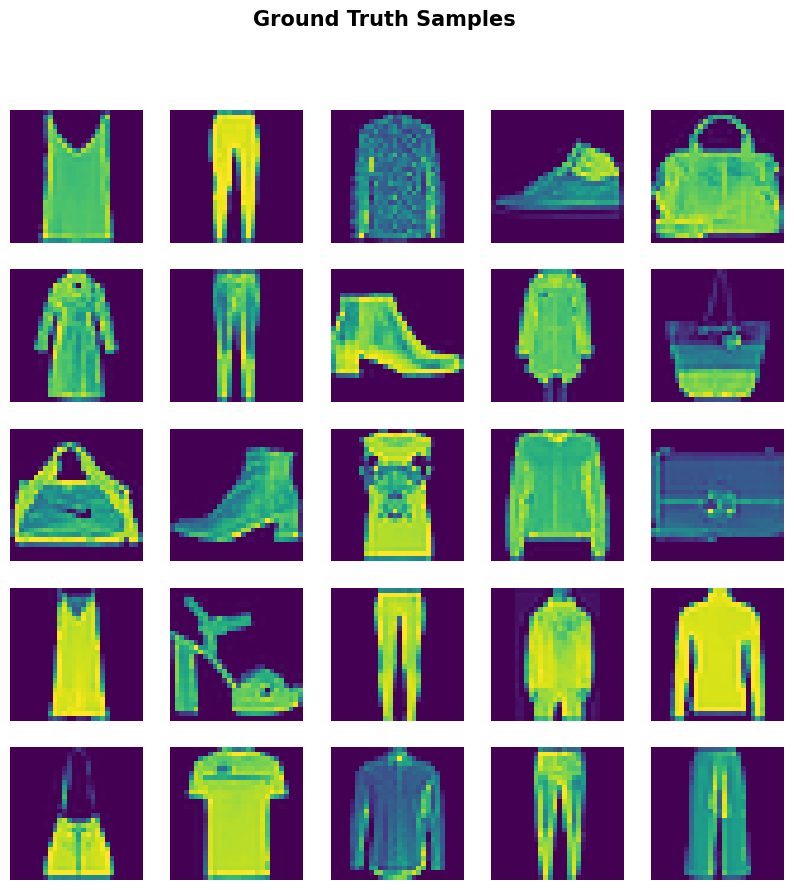

In [17]:
gt, _ = next(iter(loader))
_, ax = plt.subplots(5, 5, figsize=(10, 10))
plt.suptitle('Ground Truth Samples', fontsize=15, fontweight='bold')

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(gt[i*5+j][0])
        ax[i][j].axis('off')
plt.show()

Epoch [1/100] Loss D: 0.0421, Loss G: 4.4539
Epoch [2/100] Loss D: 0.2203, Loss G: 2.5932
Epoch [3/100] Loss D: 0.2158, Loss G: 3.8224
Epoch [4/100] Loss D: 0.3633, Loss G: 2.0789
Epoch [5/100] Loss D: 0.4809, Loss G: 1.8719
Epoch [6/100] Loss D: 0.4355, Loss G: 1.9940
Epoch [7/100] Loss D: 0.4193, Loss G: 1.6503
Epoch [8/100] Loss D: 0.2216, Loss G: 2.0989
Epoch [9/100] Loss D: 0.5171, Loss G: 1.6924
Epoch [10/100] Loss D: 0.4400, Loss G: 1.5183
Epoch [11/100] Loss D: 0.3554, Loss G: 1.7851
Epoch [12/100] Loss D: 0.6082, Loss G: 1.5703
Epoch [13/100] Loss D: 0.4840, Loss G: 1.4675
Epoch [14/100] Loss D: 0.5202, Loss G: 1.6341
Epoch [15/100] Loss D: 0.2530, Loss G: 1.9536
Epoch [16/100] Loss D: 0.4918, Loss G: 1.3229
Epoch [17/100] Loss D: 0.4494, Loss G: 1.7680
Epoch [18/100] Loss D: 0.6341, Loss G: 1.6396
Epoch [19/100] Loss D: 0.3653, Loss G: 1.4200
Epoch [20/100] Loss D: 0.8603, Loss G: 0.9524
Epoch [21/100] Loss D: 0.5276, Loss G: 1.2485
Epoch [22/100] Loss D: 0.4976, Loss G: 1.30

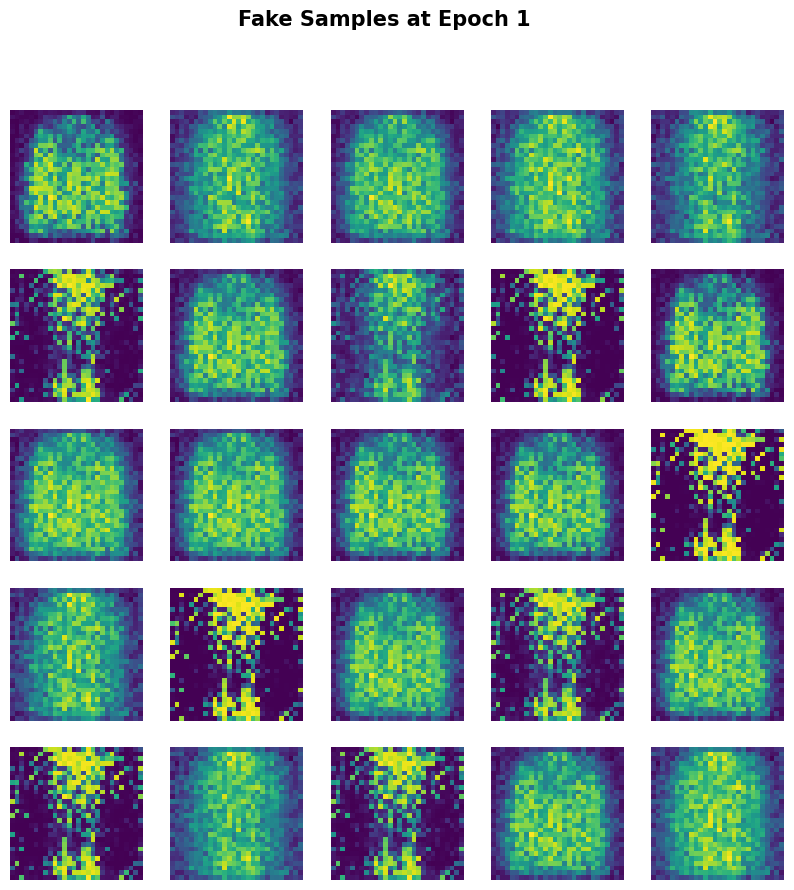

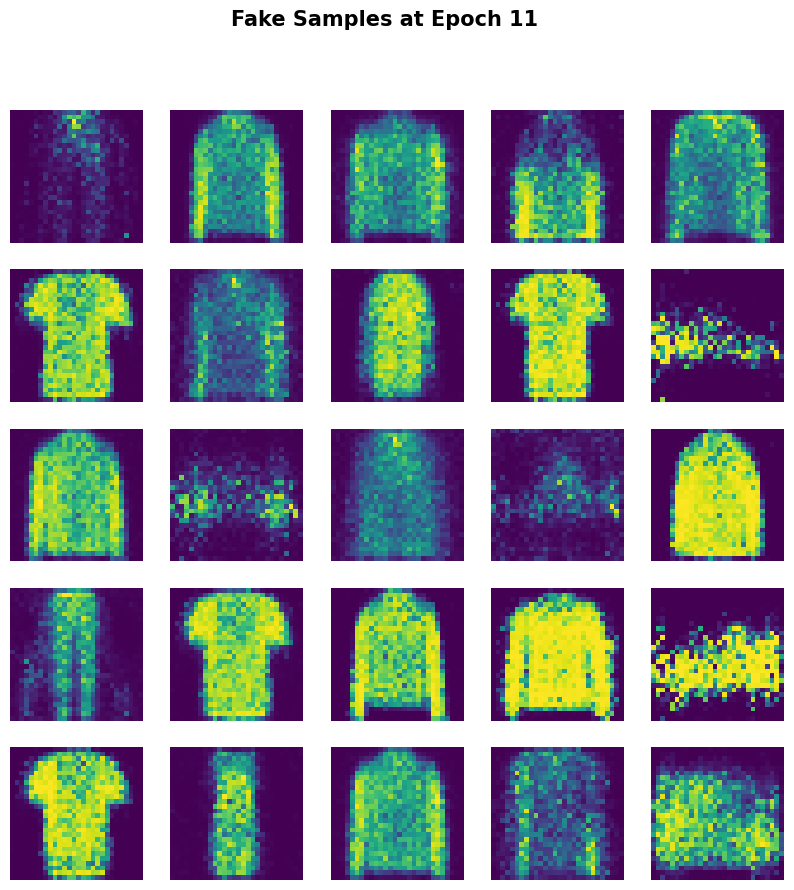

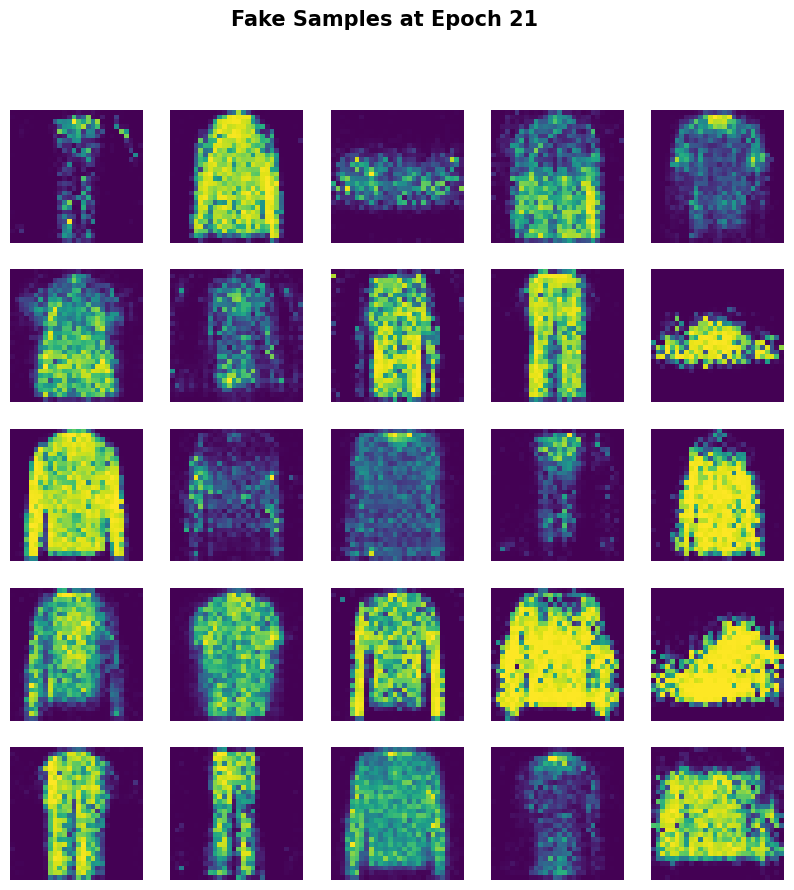

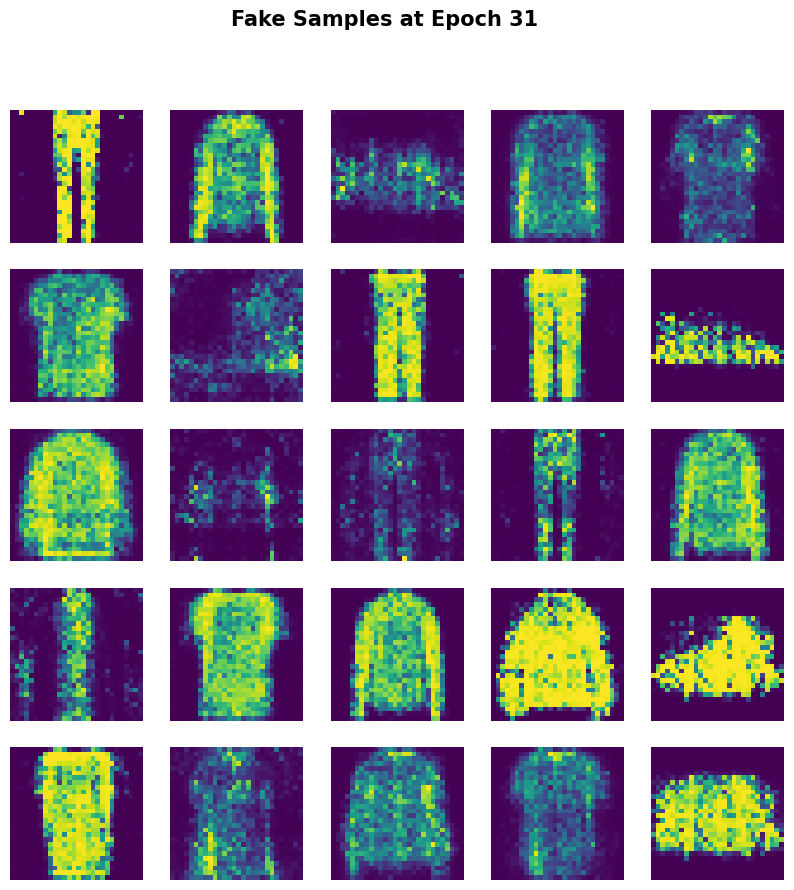

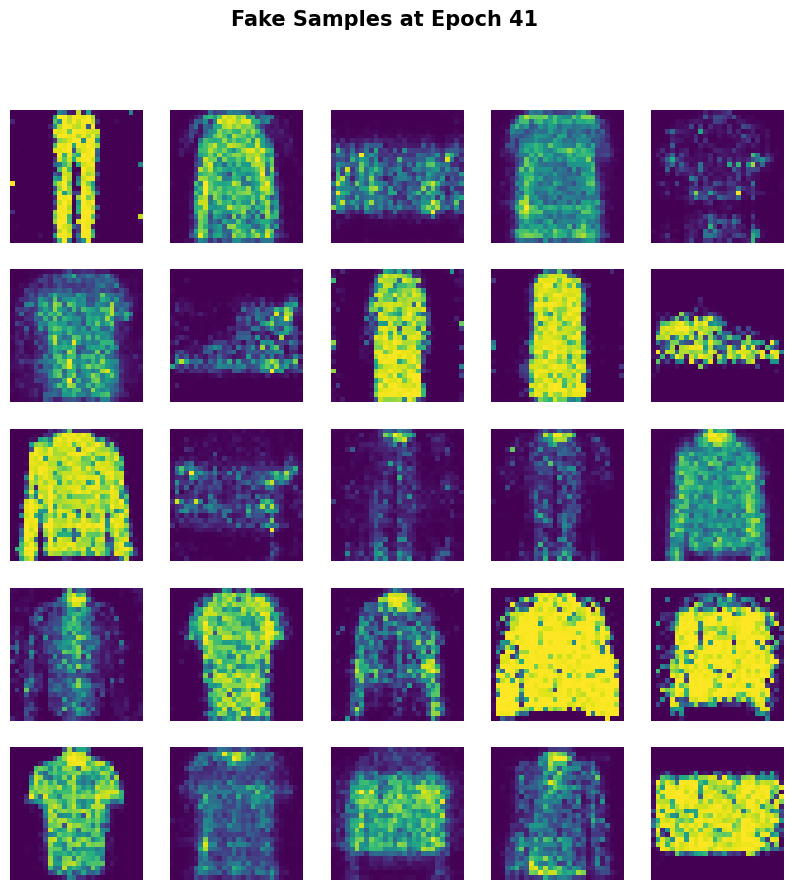

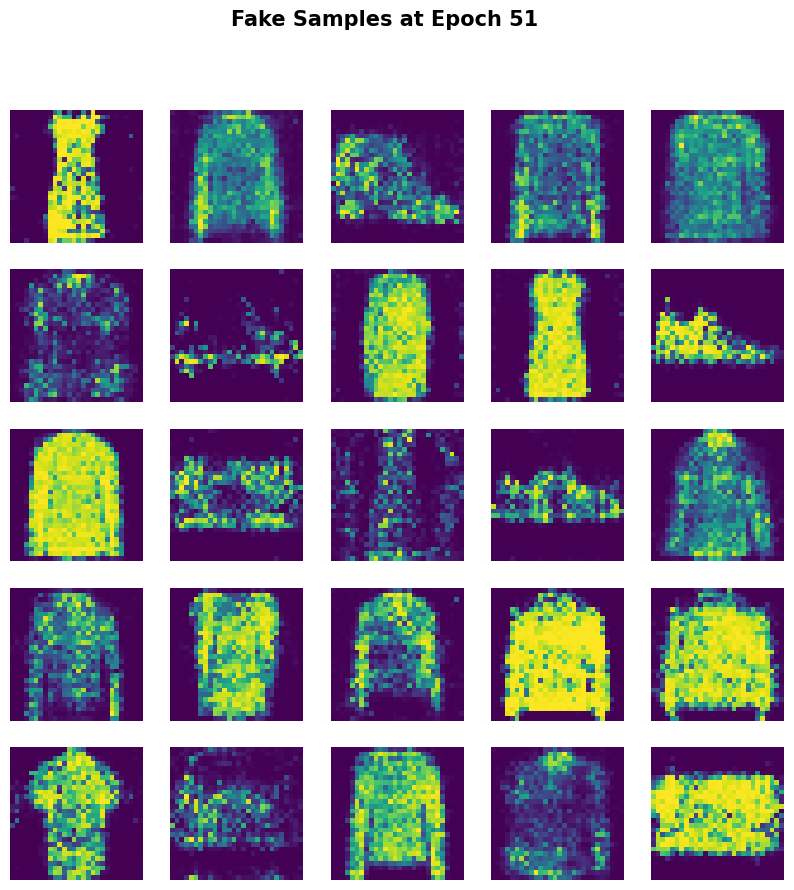

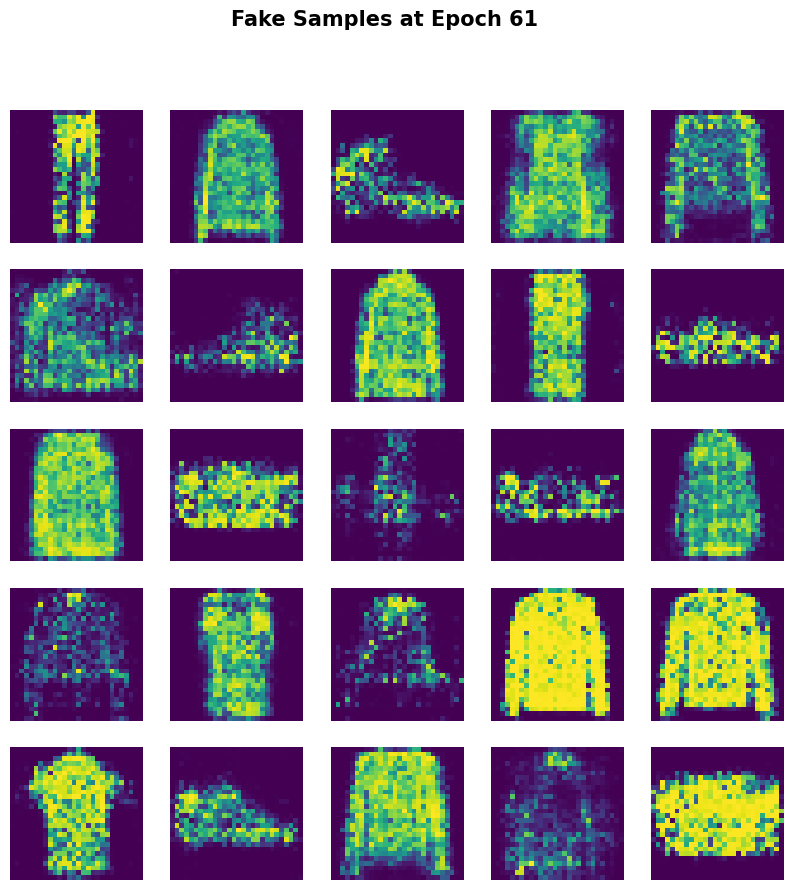

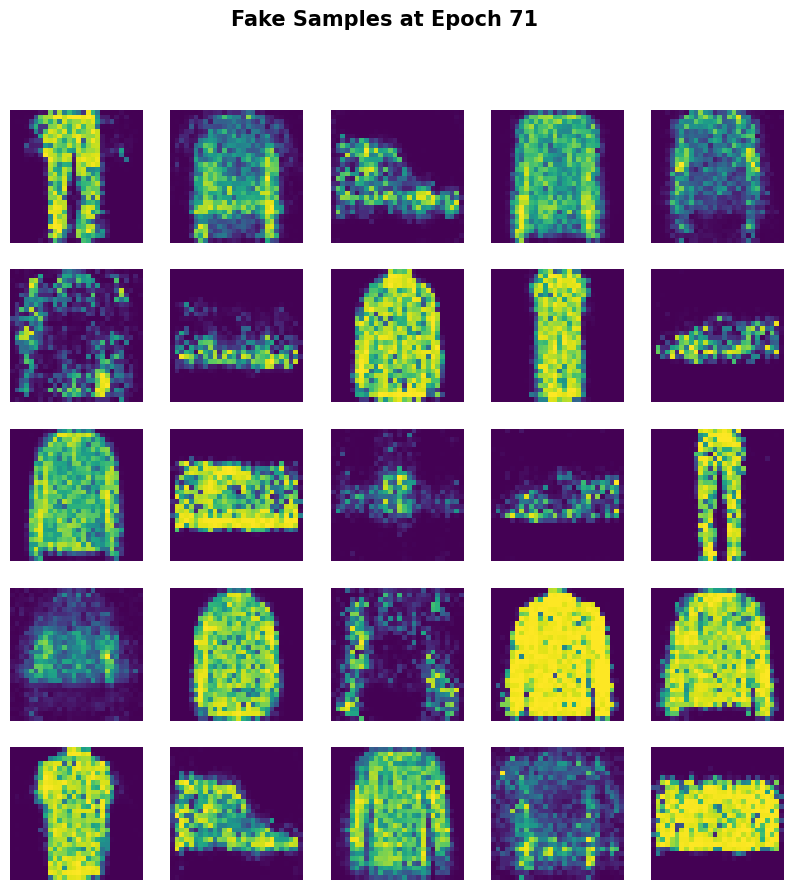

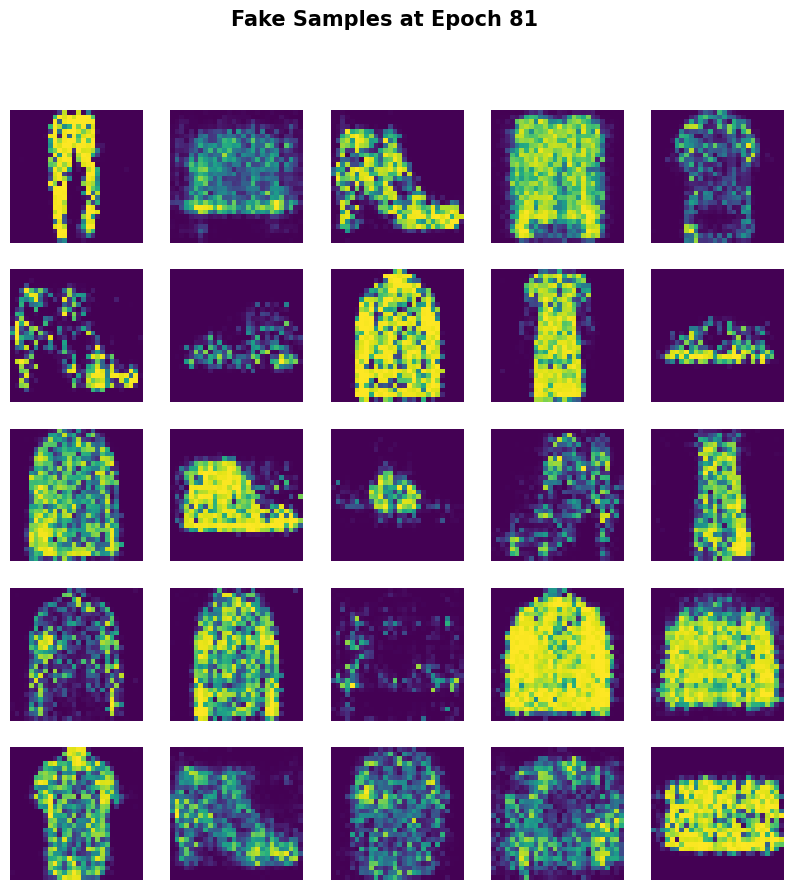

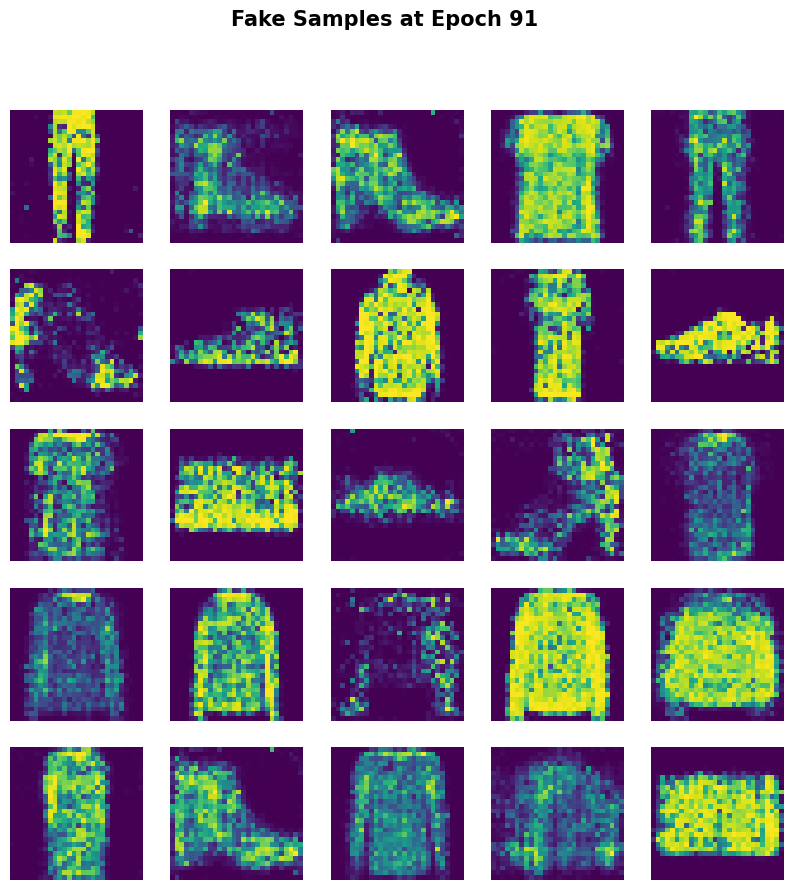

In [19]:
for epoch in range(epochs):
    for batch_idx, (gt, _) in enumerate(loader):
        gt = gt.view(-1, 784).to(device)
        batch_size = gt.shape[0]

        # Train Discriminator - max log(D(gt)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(gt).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True) # save fake in memory
        optim_disc.step()

        # Train Generator - min log(1 - D(G(z))) <=> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()

    print(f'Epoch [{epoch+1}/{epochs}] Loss D: {lossD:.4f}, Loss G: {lossG:.4f}')
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1, 1, 28, 28).cpu()

        _, ax = plt.subplots(5, 5, figsize=(10, 10))
        plt.suptitle(f'Fake Samples at Epoch {epoch+1}', fontsize=15, fontweight='bold')

        for i in range(5):
            for j in range(5):
                ax[i][j].imshow(fake[i*5+j][0])
                ax[i][j].axis('off')

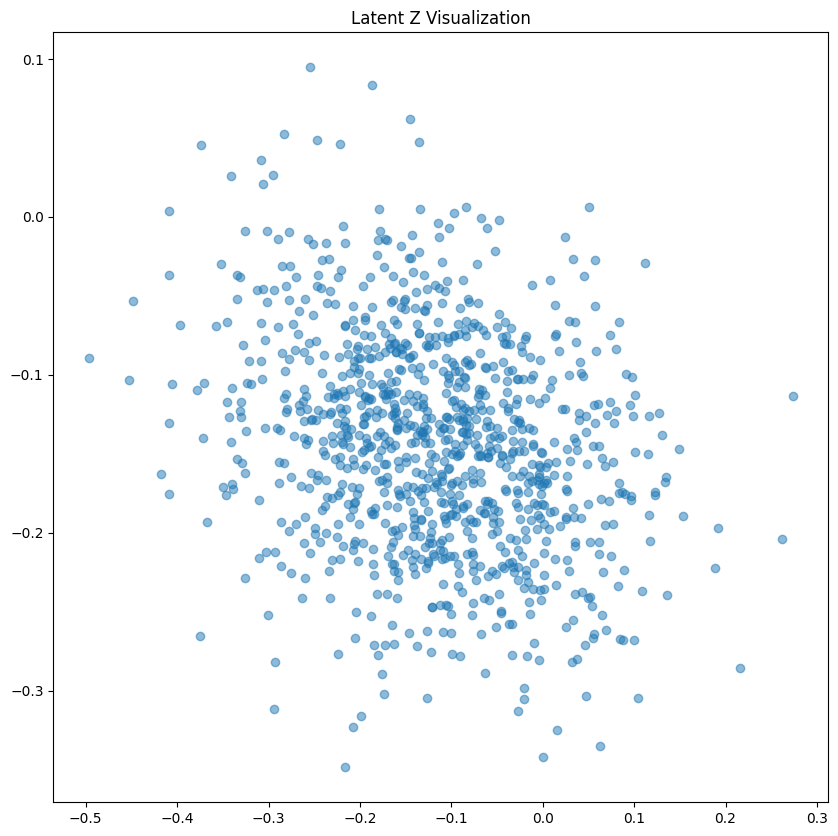

In [24]:
with torch.no_grad():
    latent_z = torch.randn(1000, z_dim).to(device)
    latent_z_embedding = gen.gen[0](latent_z).cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(latent_z_embedding[:, 0], latent_z_embedding[:, 1], alpha=0.5)
plt.title('Latent Z Visualization')
plt.show()